# sBERT

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
from sources.models import sBERTRegressor, sBERTRegressorNew, RoBERTaRegressor

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS" 
is_freeze = False  

model = sBERTRegressor(model_name, is_freeze).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

trained_model = sBERTRegressor(model_name, is_freeze).to(device)
model_path = "checkpoints/sBERT_2024-07-03 17:15:29.pth"
trained_model.load_state_dict(torch.load(model_path))

In [ ]:
example = "으아아아"
max_length = 128
encoded_text = tokenizer(example, return_tensors="pt",max_length=max_length,padding="max_length",truncation=True)
iids = encoded_text["input_ids"].to(device)
atm = encoded_text["attention_mask"].to(device)

In [ ]:
print("학습되지 않은 모델:",round(float(model(iids, atm)), 3), "점")
print("학습된 모델:",round(float(trained_model(iids, atm)), 3), "점")

In [ ]:
device = "cpu"

model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS" 
is_freeze = True  

model = sBERTRegressorNew(model_name, is_freeze, version=2).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

trained_model = sBERTRegressorNew(model_name, is_freeze, version=2).to(device)
model_path = "checkpoints/sBERTNewV2_2024-07-04_13-36-30.pth"
trained_model.load_state_dict(torch.load(model_path))

In [ ]:
example = "정말요???/????????????????????????????????????????????????/????????"
max_length = 128
encoded_text = tokenizer(example, return_tensors="pt",max_length=max_length,padding="max_length",truncation=True)
iids = encoded_text["input_ids"].to(device)
atm = encoded_text["attention_mask"].to(device)

In [ ]:
print("학습되지 않은 모델:",round(float(model(iids, atm)), 3), "점")
print("학습된 모델:",round(float(trained_model(iids, atm)), 3), "점")

# RoBERTa

In [65]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
from sources.models import sBERTRegressor, sBERTRegressorNew, RoBERTaRegressor, RoBERTaRegressorNew

device = "cpu"
is_freeze = True
max_length = 64
model_name = "klue/roberta-large" 
model_path = "checkpoints/RoBERTaNew-Large_2024-07-08_16-22-25.pth"  

model = RoBERTaRegressorNew(model_name, is_freeze).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

trained_model = RoBERTaRegressorNew(model_name, is_freeze).to(device)
trained_model.load_state_dict(torch.load(model_path))

model.eval()
trained_model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**PRETRAINED MODEL FREEZE**


Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**PRETRAINED MODEL FREEZE**


RoBERTaRegressorNew(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (La

In [66]:
from huggingface_hub import hf_hub_download
import pandas as pd
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("HF_API_KEY")
repo_id = "SaeSSak/Conversation"
file_path = hf_hub_download(repo_id, "TestData.parquet", repo_type="dataset", use_auth_token=api_key)

# 파일 로드
df = pd.read_parquet(file_path)
example = list(df["음성인식결과"])

encoded_text = tokenizer(example, return_tensors="pt",max_length=max_length,padding="max_length",truncation=True)
iids = encoded_text["input_ids"].to(device)
atm = encoded_text["attention_mask"].to(device)

In [67]:
import torch

# 모델 예측
with torch.no_grad():
    predictions = trained_model(iids, atm)

# 그래디언트 추적 분리 및 NumPy 배열 변환
predictions_numpy = predictions.detach().numpy()

# 데이터프레임에 예측 결과 추가
df["나이점수"] = df["나이"] * 10
df["예측점수"] = predictions_numpy

df["오차"] = (df["나이점수"] - df["예측점수"]).abs()

# 각 나이별로 편차 계산
age_groups = df.groupby("나이")["오차"].mean().reset_index()
overall_deviation = df["오차"].mean()

In [68]:
for ag in age_groups.values:
    print("나이:", ag[0], "  오차:", round(ag[1], 2))
print("MAE:",overall_deviation)

나이: 3.0   오차: 19.06
나이: 4.0   오차: 9.23
나이: 5.0   오차: 8.0
나이: 6.0   오차: 12.03
나이: 7.0   오차: 14.32
나이: 8.0   오차: 6.08
나이: 9.0   오차: 13.96
나이: 10.0   오차: 27.4
MAE: 13.760993766784669


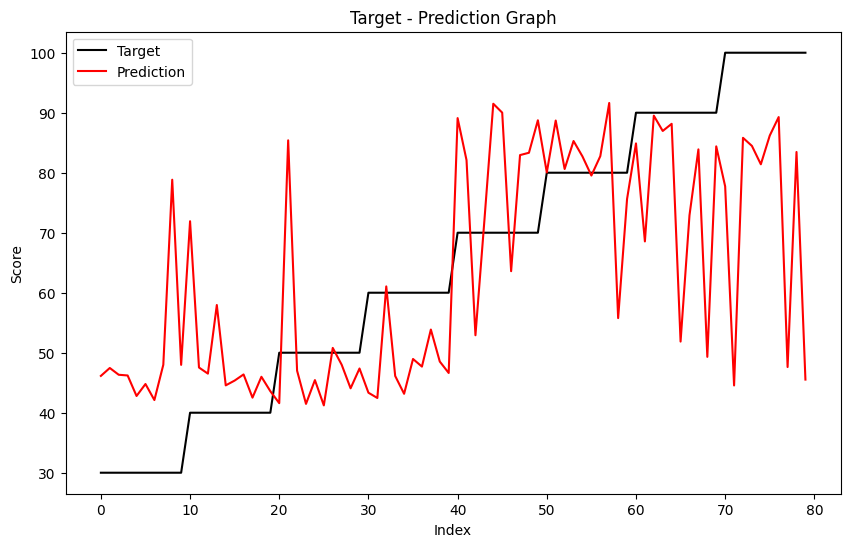

In [69]:
import matplotlib.pyplot as plt
#  그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["나이점수"], color='black', label='Target')
plt.plot(df.index, df["예측점수"], color='red', label='Prediction')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('Target - Prediction Graph')
plt.legend()
plt.show()

In [64]:
df[df["예측점수"] > 70]

,음성인식결과,지역,성별,대화주제,나이,나이점수,예측점수,오차
8,그거 먹기 싫은데,강원,남,집,3,30,87.696243,57.696243
20,요즘에는 잘 안 써,전라,남,박물관,5,50,73.312263,23.312263
21,청 신기하다 엄청 신기하다,경상,남,미용실,5,50,80.185387,30.185387
40,일교시는 아홉시에 시작해요,수도권,여,일정,7,70,79.552269,9.552269
41,아빠가 나 두산 희원권 끊어준다고 그랬어,경상,남,야구,7,70,70.297104,0.297104
44,으아 거미 내려왔어,전라,남,거미,7,70,86.036240,16.036240
45,젖소 보러 간대,수도권,남,현장 학습,7,70,85.774811,15.774811
47,화분이 흙을 부은 다음에 손가락으로 꾹 눌러서 씨앗을 넣는 거야,경상,남,식물 이야기,7,70,82.435127,12.435127
48,엄마 나 과자 먹어도 돼요,강원,여,밥투정,7,70,84.193672,14.193672
49,싫어 같이 들어가자,강원,남,영화관,7,70,86.959435,16.959435


In [58]:
name = model_path.split("/")[-1].split(".")[0]
df.to_csv(f"./result/{name}.csv", index = False)

# 모델 실험

In [ ]:
device = "cpu"

In [ ]:
example = "안녕하세요."
max_length = 128
encoded_text = tokenizer(example, return_tensors="pt",max_length=max_length,padding="max_length",truncation=True)
iids = encoded_text["input_ids"].to(device)
atm = encoded_text["attention_mask"].to(device)

In [ ]:
model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS" 
is_freeze = True 
sbert = AutoModel.from_pretrained(model_name).to(device)

In [ ]:
outputs = sbert(input_ids=iids, attention_mask=atm)

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
iids

In [ ]:
token_embeddings = outputs.last_hidden_state

In [ ]:
token_embeddings = outputs.last_hidden_state
print(token_embeddings.shape)
input_mask_expanded = atm.unsqueeze(-1).expand(token_embeddings.size()).float()
print(input_mask_expanded.shape)
sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
print(sum_embeddings.shape)
sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
print(sum_embeddings.shape)
(sum_embeddings / sum_mask).shape